In [ ]:
pip install py-pde

In [6]:
# Download a static FFmpeg build and add it to PATH.
exist = !which ffmpeg
if not exist:
  !curl https://johnvansickle.com/ffmpeg/releases/ffmpeg-release-amd64-static.tar.xz -o ffmpeg.tar.xz \
     && tar -xf ffmpeg.tar.xz && rm ffmpeg.tar.xz
  ffmdir = !find . -iname ffmpeg-*-static
  path = %env PATH
  path = path + ':' + ffmdir[0]
  %env PATH $path
print('')
!which ffmpeg
print('Done!')


./ffmpeg-5.1.1-amd64-static/ffmpeg
Done!


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FFMpegWriter
plt.rcParams['animation.ffmpeg_path'] = "./ffmpeg-5.1.1-amd64-static/ffmpeg"

3 ting vi må modellere til enhver tid:

N : Antall neurotransmitters i synpaptic cleft. Dette er en funksjon av hvor mange som blir frigjort til enhver tid (en viss sannsynlighet), hvor mange som blir tatt opp av receptors (og hvor mange som blir frigjort). Vi må også modellere posisjonen (fordelingen?) til neurotransmitters. I tillegg er det kanskje mulig at neurotransmitters forsvinner ut av synaptic cleft på sidene?

R: Antall frie receptors som er klare til å ta i mot neurotransmitters. Kan sette posisjonen her fast

B: Antall neurotransmitters som er bundet til receptors. Dette er 1-R om R summeres til 1. 

Setter c(t,x) til konsentrasjonen av neurotransmitters

p(t,x): Hvor mange ledige receptors det er (og hvor de er) 

Starter først med 1D: Vi har neurotransmitters i punkt 0, og de forflytter seg med diffusjon. Det vi i teorien skal modellere er en reaction-diffusion system, bare at de kan ikke forflytte seg etter at de har blitt bundet.

n er neurotransmitters, r er receptors og rn er bundne neurotransmitters

dn = laplace(n)-antall som blir bundet () + antall som blir frigjort

dr = - antall som blir bundet + antall som blir frigjort

drn = antall som blir bundet - antall som blir frigjort

Antall som blir bundet er en funksjon av tid og 

In [4]:
#constants
mol = 6.02214e23

h = 15e-9 #height of synpactic cleft
r = 2.2e-7 #radius of synaptic cleft
area = np.pi*r**2 #Area of synpactiv cleft
V = np.pi*r**2*h #Volume of synaptic cleft

l_d = 1e-6 #length of dendrite
dc = 8e-7 # diffusion coefficient

receptor_density = 1000*10e5*10e5 #Density of receptors, measured in number per m^2
R = receptor_density*np.pi*r**2 #The actual amount of receptors on the membrane
print(R)
neuro_released = 5000 #Number of neurotransmitters released
N = neuro_released/(mol)

k_on = 4e6 #Reaction constant on binding, measured in l/mol/s, could be changed to meters
k_on = 4e6*10e-3 #changed to m^3/(mol s)



#This means we need to just find the amount of mol per m^3 close to the receptors
k_off = 5 #Measured in s^-1
bound_receptors_transmission = 0.5 #Minimum fraction of bound receptors necessary to trigger transmission


152.053084433746


In [8]:
import numba as nb
import numpy as np
import pde
from pde import FieldCollection, PDEBase, PlotTracker, ScalarField, UnitGrid, CartesianGrid, ScalarField, MemoryStorage, FileStorage,plot_kymograph


class NeuroTransmitters2D(PDEBase):
    def __init__(self, epsilon, eta, diffusitivity, bc="auto_periodic_neumann"):
        super().__init__()
        self.epsilon = epsilon
        self.eta = eta
        self.diffusitivity = diffusitivity  # spatial mobility
        self.bc = bc  # boundary condition
        self.initial_free_receptors = None

    def get_initial_state(self, grid):
        """prepare a useful initial state"""
        shape = grid.shape
        n = ScalarField(grid, 0, label="Field $n$")
        r = ScalarField(grid, 0, label="Field $r$")
        spacing = shape[1]
        for i in range(0,shape[1]):
            n.insert(point=np.array([0,i]), amount=neuro_released/spacing) #inserting evenly spaced
            r.insert(point=np.array([shape[0],i]), amount=R/spacing) #R is the amount of receptors, add them on the other side
        rn = ScalarField(grid, 0, label="Field $rn$") #This is just 0 in the beginning
        self.initial_free_receptors = r.integral
        return FieldCollection([n,r,rn])

    def f(r,n, epsilon):
        #Idea: for a given state, the function f will calculate how many that will bound

        #Spm: her må vi velge en tid, hvor lenge det tar å binde seg? Eller holder det at epsilon avhenger av k_on som er tidsavhengig? 
        return r*n*epsilon

    def g(rn, eta):
        #idea: For a given state, the function g will calculate how many that will unbound

        return rn*eta

    def evolution_rate(self, state, t=0):
        """pure python implementation of the PDE"""
        n, r, rn = state
        rhs = state.copy()
        d = self.diffusitivity

        if r.integral <= 0.5 * self.initial_free_receptors:
            print('Signal was sent at time t={t}')
            exit()

        binding = r*n*epsilon
        unbinding = rn*eta

        rhs[0] = d*n.laplace(self.bc) - binding + unbinding
        rhs[1] = - binding + unbinding
        rhs[2] =  binding - unbinding
        return rhs

    def _make_pde_rhs_numba(self, state):
        """nunmba-compiled implementation of the PDE"""
        d0 = self.diffusitivity
        self.epsilon = epsilon
        self.eta = eta
        laplace = state.grid.make_operator("laplace", bc=self.bc)

        @nb.jit
        def pde_rhs(state_data, t):
            n = state_data[0]
            r = state_data[1]
            rn = state_data[2]
            d = self.diffusitivity

            binding = r*n*epsilon#f(r,n)
            unbinding = rn*eta#g(rn)
            rate = np.empty_like(state_data)
            rate[0] = d*laplace(n) - binding + unbinding
            rate[1] = - binding + unbinding
            rate[2] =  binding - unbinding
            return rate

        return pde_rhs

size=20

eta = k_off
dc=8e-7/(r**2)
print(dc)
k_undim = k_on/(np.pi*r**2*mol)
print(k_undim)
epsilon=k_undim



# initialize state
bounds = ((0,size),(0,size))
grid = CartesianGrid(bounds=bounds, shape=[size, size])

# Set zero Neumann boundary conditions (particles can't escape domain)
bc_x_left = {'derivative': 0}
bc_x_right = {'derivative': 0}
bc_y_left = {'derivative': 0}
bc_y_right = {'derivative': 0}
bc_x = [bc_x_left, bc_x_right]
bc_y = [bc_y_left, bc_y_right]
bc = [bc_x, bc_y]

storage = FileStorage("2dNeuro.npz")

eq = NeuroTransmitters2D(epsilon, eta,diffusitivity=dc, bc=bc)
state = eq.get_initial_state(grid)

total=0.001*10e-5
n=100

# simulate the pde
tracker = PlotTracker(interval=1, plot_args={"vmin": 0, "vmax": 5}, show=True,output_file="test.png")
sol = eq.solve(state, t_range=total, dt=total/n,tracker=tracker)#storage.tracker(0.1))


ModuleNotFoundError: No module named 'pde'

In [ ]:
pde.movie(storage, filename="2dNeuro.mov")
# plot the resulting field

# visualize the result in a space-time plot
plot_kymograph(storage)

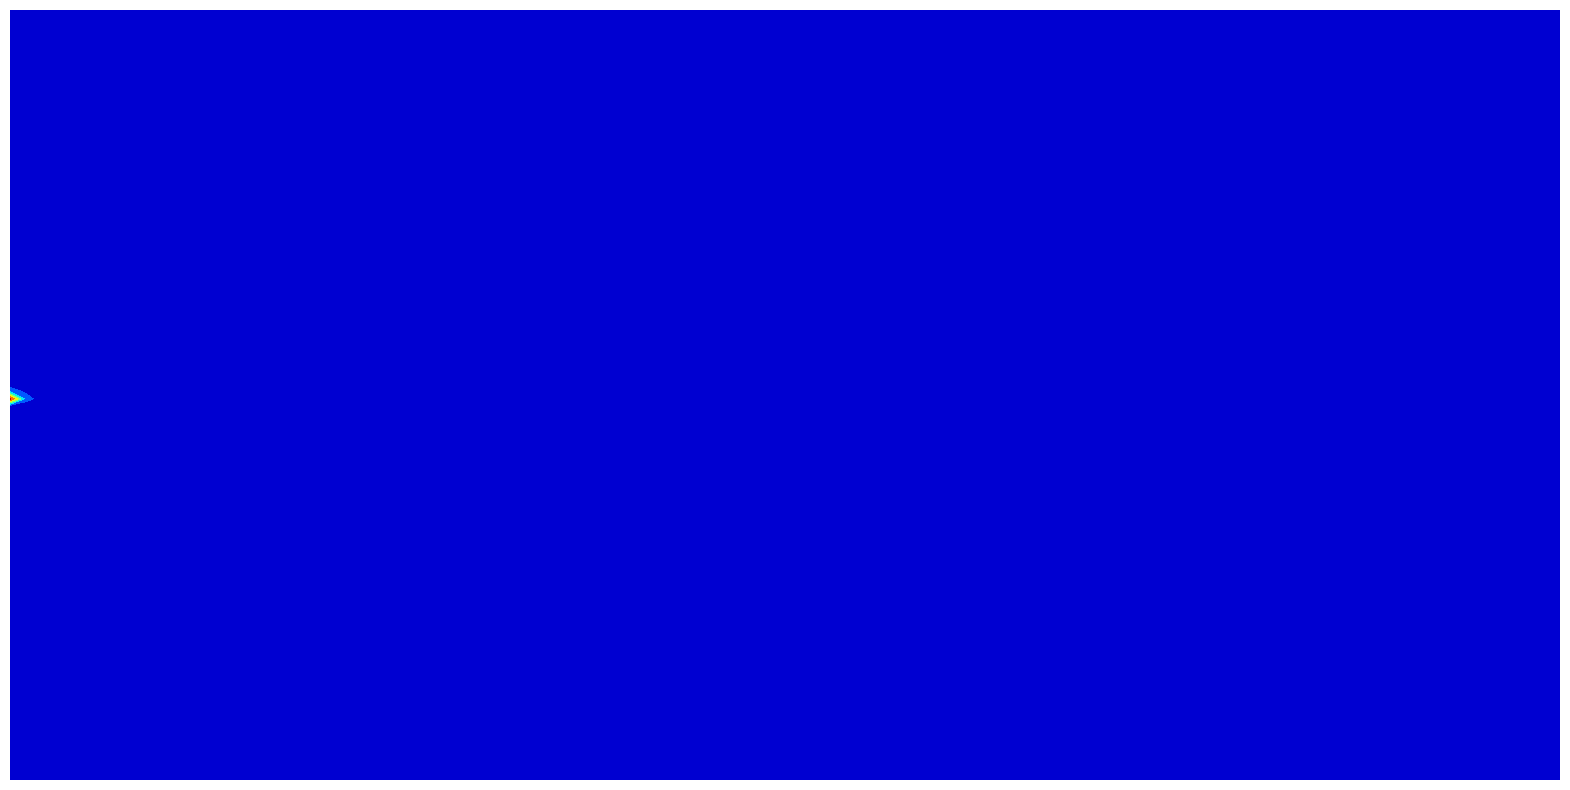

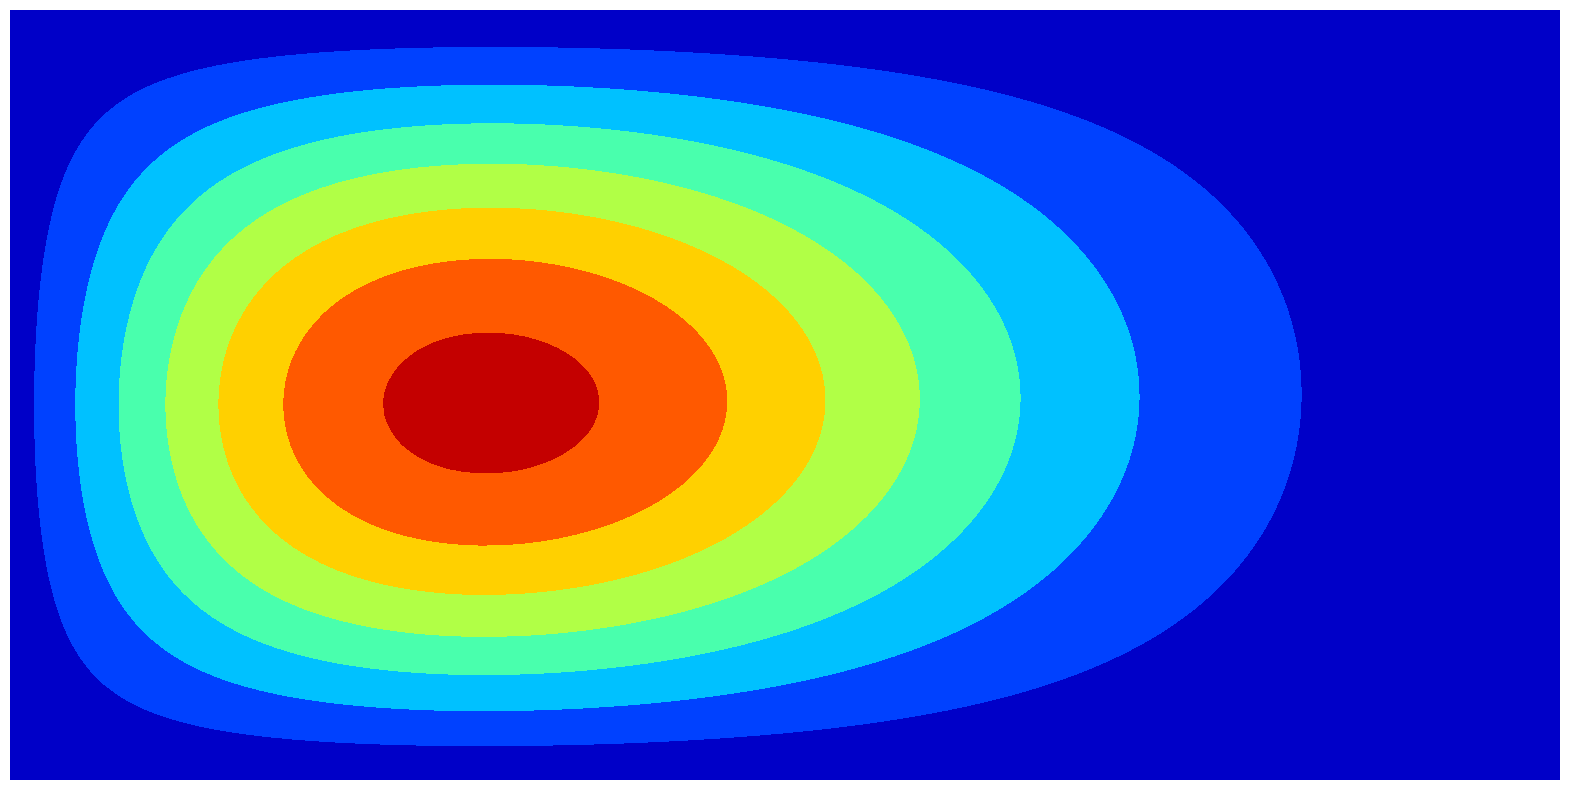

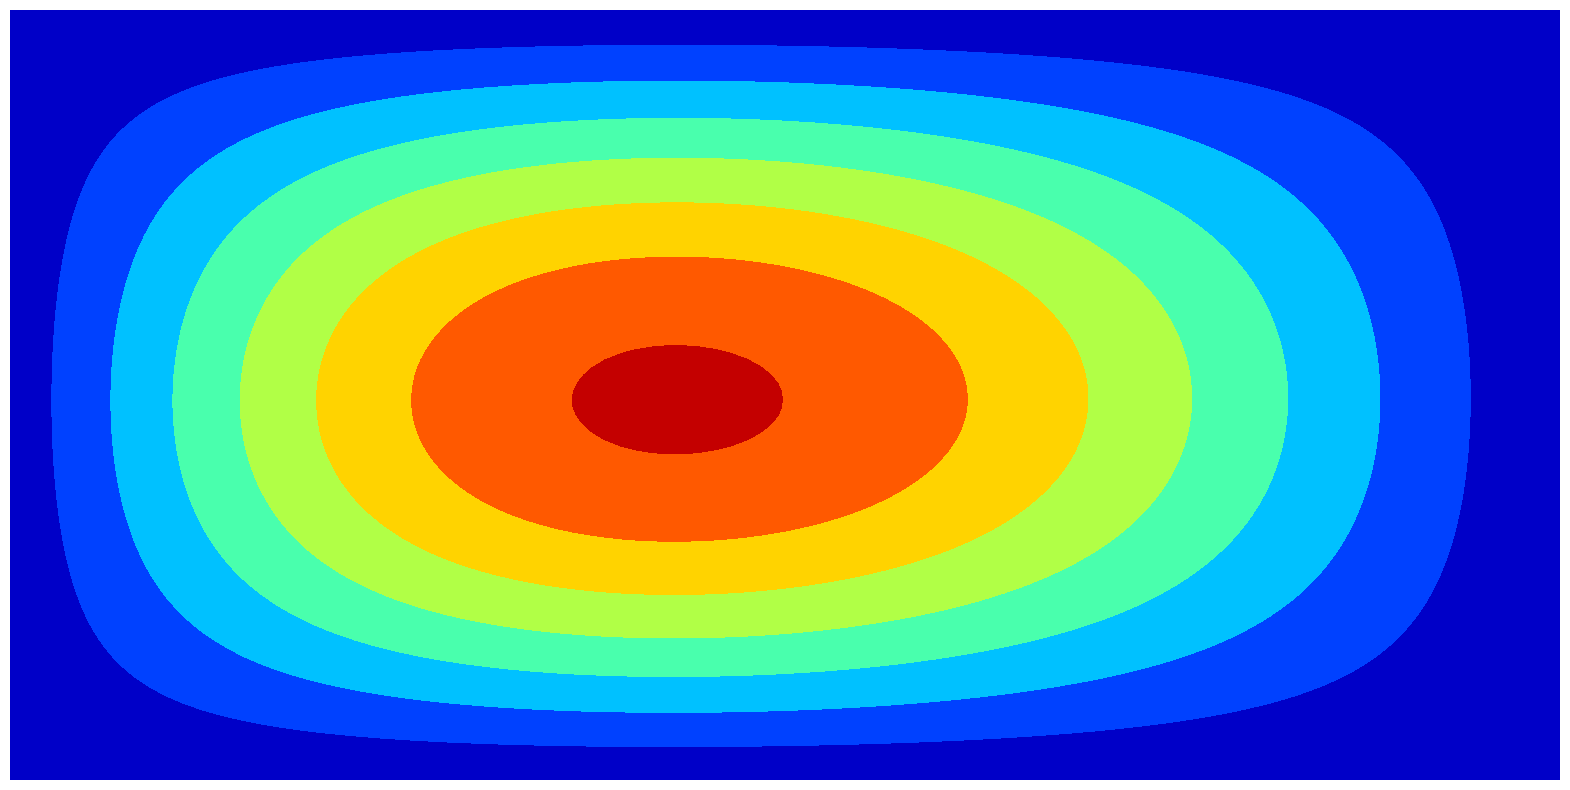

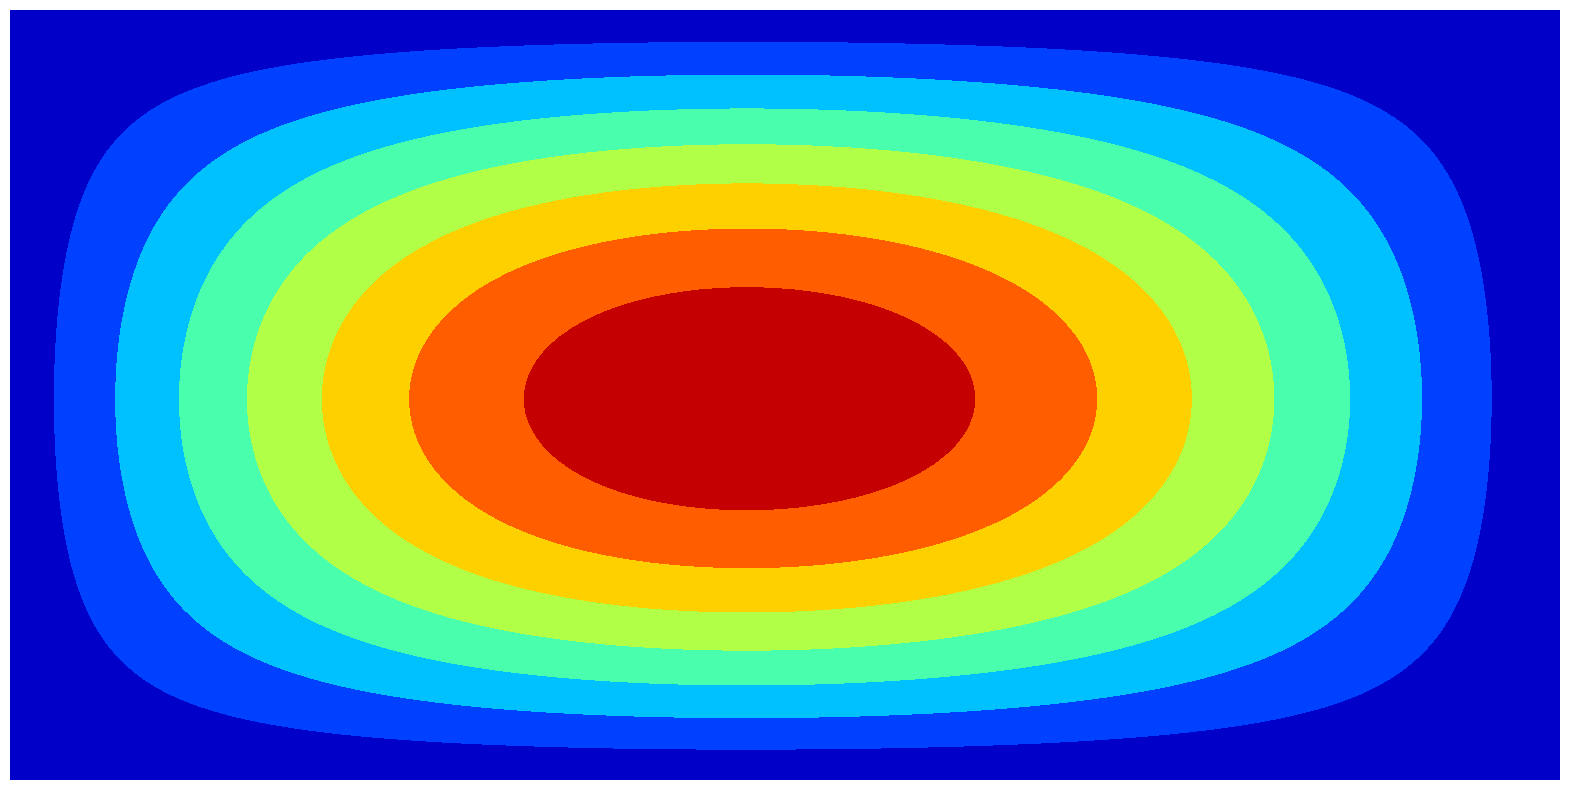

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
sns.set()


T = 4000
u = np.zeros((100,100))
u[50,0] = 5000

def ans(f):
    global u, plot
    
    #Time is not defined as the animation will do the loop for T times.
    for j in range(99):
        for i in range(1,99):
            u[i,j] += (u[i+1,j] + u[i,j+1] + u[i-1,j] + u[i,j-1] - 4*u[i,j])/4
    return u

#anim = animation.FuncAnimation(fig, ans, frames=T)
for i in range(T):
    u=ans(u)
    if i%1000==0:
        fig, ax = plt.subplots(figsize=(20,10))
        ax.axis('off')
        plot = ax.contourf(u, cmap='jet')
        plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8fa4b93d-2b12-4306-b794-0842afddf55c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>